In [1]:
import requests
import pandas as pd

# URL of the file in the GitHub repository
url = "https://raw.githubusercontent.com/blueprints-for-text-analytics-python/blueprints-text/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz"

# Download the file
response = requests.get(url)
open("eclipse_jdt.csv.gz", "wb").write(response.content)

# Load the CSV file into a DataFrame
df = pd.read_csv("eclipse_jdt.csv.gz", compression='gzip')

# Display the first few rows
print(df.head())

# Display basic info about the DataFrame
print(df.info())

   Issue_id Priority Component  Duplicated_issue  \
0      1518       P1     Debug               NaN   
1      1519       P3     Debug               NaN   
2      1520       P3     Debug               NaN   
3      1521       P3     Debug               NaN   
4      1522       P2     Debug            1663.0   

                                               Title  \
0                 Icons needed for actions (1GI5UXW)   
1              README: Hit count not reset (1GET20Y)   
2               Use styled text in console (1G9S1YF)   
3              StringBuffer representation (1GE3BFA)   
4  Feature: use #toString to display variable val...   

                                         Description    Status  Resolution  \
0  JGS (8/8/01 5:20:19 PM); \tWe need enabled; di...  VERIFIED       FIXED   
1  JGS (6/4/01 11:43:47 AM); \tSet a breakpoint i...  RESOLVED  WORKSFORME   
2  DW (2/26/01 5:56:36 PM); \tCould allow users t...    CLOSED     WONTFIX   
3  JGS (5/21/01 2:09:10 PM); \tTo be c

## df에 대한 정보

### issue_id: 버그를 추적하는데 사용되는 이슈의 기본 키
### Priority: p1(가장중요)에서 p5(가장 덜 중요)까지 버그의 다양한 심각도(범주형 필드)를 정의
### Component: 버그가 발생한 프로젝트의 특정 아키텍처를 나타낸다. U1, APT등이 될 수 있다.(범주형 필드)
### Title: 전체 텍스트 필드
### Description: 버그 재현 경로와 버그가 소프트웨어 사용에 미치는 영향을 자세히 기술.

In [2]:
print(df.columns)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


In [3]:
df[['Issue_id','Priority','Component','Title','Description']].sample(2)

,Issue_id,Priority,Component,Title,Description
43013,359284,P3,Core,Unnecessary checkast from null,Consider the following Java snippet:; ; public...
36874,211037,P3,UI,[infer type arguments] UnsupportedOperationExc...,When attempting to Infer Generic Type Argument...


In [4]:
df.sample(1).T

,30915
Issue_id,131874
Priority,P3
Component,UI
Duplicated_issue,NaN
Title,[doc] Better explain Java > Compiler > Javadoc...
Description,I20060314-1200; ; The Java > Compiler > Javad...
Status,RESOLVED
Resolution,FIXED
Version,3.2
Created_time,2006-03-15 02:32:00 -0500


<Axes: xlabel='Priority'>

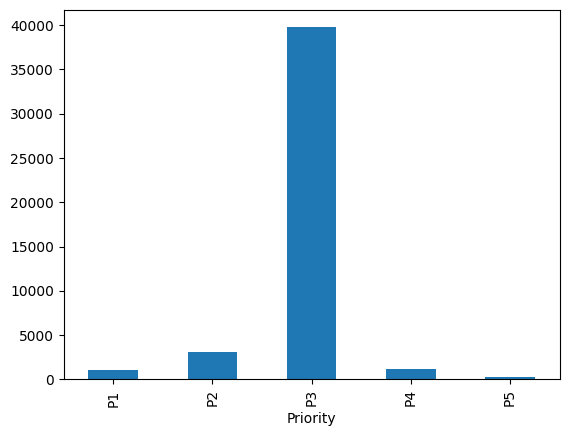

In [5]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [6]:
df['Component'].value_counts()

,count
Component,
UI,17479
Core,13669
Debug,7542
Text,5901
APT,406
Doc,299


## 텍스트 분류 시스템 구축

  - 데이터 준비: 텍스트 분류 모델 구축을 진행하기 전에 데이터를 정리하고 머신러닝 알고리즘을 적용하기에 적합한 형태로 바꿈
  - 여기서 목표는 제목과 설명이 주어진 버그 보고서의 우선순위를 식별하는 것이므로 텍스트 분류 모델과 관련된 열만 선택한다. 그 후 특수문자를 제거한 후 텍스트 필드에 50자 미만인 관측 데이터를 필터링한다. 50자 미만의 버그 보고서는 올바르게 작성되지 않는다.

In [7]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [8]:
import re

def clean(text):
    # 텍스트 정리 로직 예시
    text = text.lower()  # 소문자로 변환
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 불필요한 공백 제거
    return text

df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

,Priority,text
8517,P3,error ticks dont show up in types view 2002091...
23262,P4,internal error logged on edited stack trace i2...


# 훈련-테스트 분할
- 1. 100개의 데이텟에서 80:20 비율로 훈련-테스트 분할을 적용하면 80개 관측치가 훈련 분할이 되고 20개 관측치가 테스트 분할이 된다.

- 2. 80개 관측치를 가진 훈련 데이터로 학습된 함수가 제대로 학습됐는지 평가하기 위해 테스트 분할을 학습된 함수에 적용해 예측 결과를 얻는다.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print("Size of Training Data: ", X_train.shape[0])
print("Size of Test Data: ", X_test.shape[0])

Size of Training Data:  36055
Size of Test Data:  9014


## 머신러닝 모델 훈련
 - 이제는 적절한 알고리즘을 사용해 지도 머신러닝 모델을 훈련하는 것이다.
 - (X-Y 평면에 있는 각 점은 두 클래스 중 하나에 속한다. SVM은 두 클래스를 명확하게 구분하는 선이다.)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words="english")
X_train_df = tfidf.fit_transform(X_train)

In [11]:
from sklearn.svm import LinearSVC
model1= LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_df, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [12]:
# 우선순위가 P3인 버그 보고서를 필터링하고 4000개 행을 샘플링 한다.
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000)

# 다른 모든 버그 보고서를 포함하는 별도의 데이터프레임을 만든다.
df_sampleRest = df[df['Priority'] != 'P3']

# 두 개의 데이터프레임을 연결해 균형이 잡힌 새 버그 보고서 데이터셋을 만든다.
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
df = df_balanced[['text','Priority']]
df = df.dropna()
# 데이터준비
df['text'] = df['text'].apply(clean)
# step2 - 훈련 테스트 분할
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print("Size of Training Data:", X_train.shape[0])
print("Size of Test Data:", X_test.shape[0])

# 머신러닝 훈련 모델
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words='english')
X_train_df = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_df, Y_train)

# 모델 평가
X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print("Accuracy Score:",accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data: 7639
Size of Test Data: 1910
Accuracy Score: 0.5
              precision    recall  f1-score   support

          P1       0.43      0.30      0.36       224
          P2       0.44      0.45      0.44       608
          P3       0.56      0.67      0.61       800
          P4       0.46      0.36      0.40       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1910
   macro avg       0.38      0.35      0.36      1910
weighted avg       0.48      0.50      0.49      1910



## 모델 평가
  - 모델의 정확도를 수치화하는데 사용할 수 있는 메트릭
  정확도: 정확한 예측횟수/총예측횟수


In [14]:
from sklearn.metrics import accuracy_score
X_test_tf = tfidf.transform(X_test)

Y_pred = model1.predict(X_test_tf)
print("Accuracy Score - ", accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.5


## 교차 검증을 사용한 현실적인 정확도 메트릭 추정

In [15]:
from sklearn.model_selection import cross_val_score
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words='english')
df_tf = tfidf.fit_transform(df['text']).toarray()
# 5. 폴드 교차 검증
scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df['Priority'],
                         cv=5)

print("Validation scores from each iteration of the cross validation:", scores)
print("Mean value across of validation scores:", scores.mean())
print("Standard deviation of validation scores:", scores.std())

Validation scores from each iteration of the cross validation: [0.47120419 0.43298429 0.42408377 0.4        0.35358827]
Mean value across of validation scores: 0.416372103483362
Standard deviation of validation scores: 0.03886347435601591


# 그리드 검색을 통한 하이퍼파라미터 조정
  - 1. 장점: 그리드 검색은 모델의 인수로 사용되는 다양한 매개변수를 조정 및 평가해 모델의 정확도를 향상시키는 유용한 기술, 그리드 검색을 수행할 때, 평가하려는 인자를 여러가지 값으로 변경하면서 테스트할 수 있다.그리드 검색을 수행할 때, 평가하려는 매개변수 값 세트를 제공하고 모델 훈련의 교차 검증 방법과 결합해 모델 정확도를 최대화하는 하이퍼파라미터 세트를 찾는다.

  - 2. 단점: CPU와 시간 집약적이라는 것이다.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# 파이프라인 정의
training_pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer(stop_words="english")),
        ('model', LinearSVC(random_state=42, tol=1e-5))
    ]
)

# GridSearch를 위한 매개변수 설정
grid_param = [
    {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__penalty': ['l2'],  # LinearSVC에서는 유효하지 않은 매개변수, 제거 필요
        'model__loss': ['hinge'],  # LinearSVC에서는 'penalty'와 'loss' 미지원, 제거 필요
        'model__max_iter': [10000]
    },
    {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 10],
        'model__tol': [1e-2, 1e-3]  # 'MODEL__tol'을 'model__tol'로 수정
    }
]

# GridSearchCV 실행
gridSearchProcessor = GridSearchCV(
    estimator=training_pipeline,
    param_grid=grid_param,
    cv=5
)

# 데이터에 대해 GridSearch 실행
gridSearchProcessor.fit(df['text'], df['Priority'])

# 최적 매개변수와 점수 출력
best_params = gridSearchProcessor.best_params_
print("GridSearch가 선택한 최적의 매개변수:", best_params)

best_result = gridSearchProcessor.best_score_
print("GridSearch가 선택한 최적의 결과:", best_result)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearch가 선택한 최적의 매개변수: {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 6)}
GridSearch가 선택한 최적의 결과: 0.4363729811117906


In [18]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score','mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]
## 상위 5개 모델과 해당 매개변수 값을 확인할 수 있다.

,rank_test_score,mean_test_score,params
3,1,0.436373,"{'model__loss': 'hinge', 'model__max_iter': 10..."
0,2,0.436164,"{'model__loss': 'hinge', 'model__max_iter': 10..."
1,3,0.435745,"{'model__loss': 'hinge', 'model__max_iter': 10..."
2,4,0.435117,"{'model__loss': 'hinge', 'model__max_iter': 10..."
9,5,0.421818,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__m..."


# 텍스트 분류 시스템 결론 및 최종 모델